In [ ]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive')
PROJECT_PATH = '/content/drive/MyDrive/ml/ml_Assignment4'
os.chdir(PROJECT_PATH)
sys.path.append('./src')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from models.simple_cnn import SimpleCNN
from data_loader import FERDataset, get_data_transforms, create_data_loaders
from training.trainer import FERTrainer
from training.utils import plot_training_curves
from evaluation.metrics import evaluate_model, plot_confusion_matrix

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


CUDA available: True
GPU: Tesla T4


In [ ]:
wandb.login(key='')

config = {
    'experiment_name': 'baseline_simple_cnn',
    'model_name': 'SimpleCNN',
    'batch_size': 32,
    'learning_rate': 1e-3,
    'epochs': 25,
    'dropout_rate': 0.5,
    'optimizer': 'adam',
    'scheduler': 'step',
    'step_size': 8,
    'gamma': 0.1,
    'data_augmentation': False,
    'weight_decay': 1e-4,
    'patience': 8,
    'momentum': 0.9
}

wandb.init(
    project="facial-expression-recognition",
    name=config['experiment_name'],
    config=config,
    tags=["baseline", "simple-cnn", "no-augmentation"]
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: egval20 (gval0) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
train_csv_path = './data/raw/train.csv'

In [ ]:
train_transform, val_transform = get_data_transforms(augment=config['data_augmentation'])

train_loader, val_loader = create_data_loaders(
    train_csv_path,
    batch_size=config['batch_size'],
    val_split=0.2,
    train_transform=train_transform,
    val_transform=val_transform,
    num_workers=2
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

   • Train batches: 718
   • Validation batches: 180


In [ ]:
train_samples = len(train_loader) * config['batch_size']
val_samples = len(val_loader) * config['batch_size']
print(f"Train samples: ~{train_samples:,}")
print(f"Validation samples: ~{val_samples:,}")

Train samples: ~22,976
Validation samples: ~5,760


In [ ]:
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
                 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
sample_batch = next(iter(train_loader))
images, labels = sample_batch

### Model Creation and Analysis

baseline model

In [ ]:
model = SimpleCNN(num_classes=7, dropout_rate=config['dropout_rate'])
model = model.to(device)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print("Model Architecture:")
print(model)
print(f"\n📈 Model Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB (float32)")

wandb.log({
    "total_parameters": total_params,
    "trainable_parameters": trainable_params,
    "model_size_mb": total_params * 4 / 1024 / 1024
})

wandb.watch(model, log_freq=100)

Model Architecture:
SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

📈 Model Statistics:
  Total parameters: 4,741,511
  Trainable parameters: 4,741,511
  Model size: ~18.09 MB (float32)


In [ ]:
# Forward pass
sample_batch = next(iter(train_loader))
sample_images, sample_labels = sample_batch
sample_images = sample_images.to(device)

with torch.no_grad():
    outputs = model(sample_images)
    print(f"Input shape: {sample_images.shape}")
    print(f"Output shape: {outputs.shape}")
    print(f"Output range: [{outputs.min():.3f}, {outputs.max():.3f}]")

Input shape: torch.Size([32, 1, 48, 48])
Output shape: torch.Size([32, 7])
 Output range: [-0.143, 0.105]


In [ ]:
# Loss
criterion = nn.CrossEntropyLoss()
random_loss = criterion(outputs, sample_labels.to(device))
expected_loss = np.log(7)
print(f"Random prediction loss: {random_loss.item():.3f}")
print(f"Expected loss ~{expected_loss:.3f} for {len(emotion_labels)} classes")
print(f"Looking at loss: {abs(random_loss.item() - expected_loss)}")


Random prediction loss: 1.949
Expected loss ~1.946 for 7 classes
Looking at loss: 0.0029460854951628423


In [ ]:
# Small Overfitting
small_model = SimpleCNN(num_classes=7, dropout_rate=0.0).to(device)
small_optimizer = optim.Adam(small_model.parameters(), lr=1e-2)

small_images, small_labels = sample_images[:5], sample_labels[:5].to(device)

small_model.train()
initial_loss = None
for epoch in range(20):
    small_optimizer.zero_grad()
    outputs = small_model(small_images)
    loss = criterion(outputs, small_labels)
    if initial_loss is None:
        initial_loss = loss.item()
    loss.backward()
    small_optimizer.step()

    if epoch % 5 == 0:
        print(f"   Epoch {epoch:2d}: Loss = {loss.item():.4f}")

final_loss = loss.item()
print(f'final Loss: {final_loss}')

   Epoch  0: Loss = 1.9256
   Epoch  5: Loss = 0.3417
   Epoch 10: Loss = 0.0001
   Epoch 15: Loss = 0.0000
final Loss: 0.0


## Train

In [ ]:
trainer = FERTrainer(model, device, config)

print("Training Configuration:")
print(f"   • Optimizer: {config['optimizer']}")
print(f"   • Learning Rate: {config['learning_rate']}")
print(f"   • Batch Size: {config['batch_size']}")
print(f"   • Epochs: {config['epochs']}")
print(f"   • Dropout Rate: {config['dropout_rate']}")
print(f"   • Weight Decay: {config['weight_decay']}")
print(f"   • Scheduler: {config['scheduler']}")
print(f"   • Early Stopping Patience: {config['patience']}")

Training Configuration:
   • Optimizer: adam
   • Learning Rate: 0.001
   • Batch Size: 32
   • Epochs: 25
   • Dropout Rate: 0.5
   • Weight Decay: 0.0001
   • Scheduler: step
   • Early Stopping Patience: 8


In [ ]:
start_time = time.time()

best_val_acc = trainer.train(train_loader, val_loader, config['epochs'])

end_time = time.time()
training_time = end_time - start_time


Epoch 1/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 32.55it/s]


Train Loss: 1.6405, Train Acc: 35.05%
Val Loss: 1.4896, Val Acc: 41.79%
New best model saved with validation accuracy: 41.79%

Epoch 2/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 28.24it/s]


Train Loss: 1.4466, Train Acc: 43.77%
Val Loss: 1.3863, Val Acc: 47.40%
New best model saved with validation accuracy: 47.40%

Epoch 3/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 27.43it/s]


Train Loss: 1.3343, Train Acc: 48.52%
Val Loss: 1.3287, Val Acc: 47.78%
New best model saved with validation accuracy: 47.78%

Epoch 4/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 27.43it/s]


Train Loss: 1.2503, Train Acc: 52.25%
Val Loss: 1.3272, Val Acc: 48.27%
New best model saved with validation accuracy: 48.27%

Epoch 5/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 29.62it/s]


Train Loss: 1.1686, Train Acc: 55.63%
Val Loss: 1.2697, Val Acc: 51.21%
New best model saved with validation accuracy: 51.21%

Epoch 6/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 33.11it/s]


Train Loss: 1.0872, Train Acc: 58.97%
Val Loss: 1.2912, Val Acc: 51.52%
New best model saved with validation accuracy: 51.52%

Epoch 7/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 36.68it/s]


Train Loss: 1.0165, Train Acc: 62.11%
Val Loss: 1.2651, Val Acc: 53.11%
New best model saved with validation accuracy: 53.11%

Epoch 8/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 38.16it/s]


Train Loss: 0.9405, Train Acc: 64.52%
Val Loss: 1.2713, Val Acc: 53.48%
New best model saved with validation accuracy: 53.48%

Epoch 9/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 38.87it/s]


Train Loss: 0.7781, Train Acc: 71.93%
Val Loss: 1.2988, Val Acc: 54.47%
New best model saved with validation accuracy: 54.47%

Epoch 10/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 38.72it/s]


Train Loss: 0.7405, Train Acc: 73.27%
Val Loss: 1.3151, Val Acc: 54.14%

Epoch 11/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 37.86it/s]


Train Loss: 0.7091, Train Acc: 74.30%
Val Loss: 1.3205, Val Acc: 54.64%
New best model saved with validation accuracy: 54.64%

Epoch 12/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 37.51it/s]


Train Loss: 0.6875, Train Acc: 74.87%
Val Loss: 1.3317, Val Acc: 54.24%

Epoch 13/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 38.08it/s]


Train Loss: 0.6668, Train Acc: 75.94%
Val Loss: 1.3433, Val Acc: 54.66%
New best model saved with validation accuracy: 54.66%

Epoch 14/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 38.54it/s]


Train Loss: 0.6483, Train Acc: 76.68%
Val Loss: 1.3513, Val Acc: 54.52%

Epoch 15/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 38.50it/s]


Train Loss: 0.6290, Train Acc: 77.27%
Val Loss: 1.3713, Val Acc: 54.66%

Epoch 16/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 37.39it/s]


Train Loss: 0.6088, Train Acc: 78.03%
Val Loss: 1.3772, Val Acc: 54.59%

Epoch 17/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 32.40it/s]


Train Loss: 0.5822, Train Acc: 79.26%
Val Loss: 1.3801, Val Acc: 54.75%
New best model saved with validation accuracy: 54.75%

Epoch 18/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 29.71it/s]


Train Loss: 0.5698, Train Acc: 79.41%
Val Loss: 1.3873, Val Acc: 54.87%
New best model saved with validation accuracy: 54.87%

Epoch 19/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 27.37it/s]


Train Loss: 0.5784, Train Acc: 79.25%
Val Loss: 1.3887, Val Acc: 54.87%

Epoch 20/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 27.71it/s]


Train Loss: 0.5678, Train Acc: 80.04%
Val Loss: 1.3924, Val Acc: 54.82%

Epoch 21/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 30.82it/s]


Train Loss: 0.5667, Train Acc: 79.59%
Val Loss: 1.3940, Val Acc: 54.80%

Epoch 22/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 35.52it/s]


Train Loss: 0.5670, Train Acc: 79.45%
Val Loss: 1.3940, Val Acc: 54.90%
New best model saved with validation accuracy: 54.90%

Epoch 23/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 38.81it/s]


Train Loss: 0.5655, Train Acc: 79.51%
Val Loss: 1.3971, Val Acc: 54.87%

Epoch 24/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 38.64it/s]


Train Loss: 0.5687, Train Acc: 79.79%
Val Loss: 1.3969, Val Acc: 54.73%

Epoch 25/25
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 38.99it/s]

Train Loss: 0.5607, Train Acc: 80.18%
Val Loss: 1.3975, Val Acc: 54.71%


In [ ]:
wandb.log({
    "best_validation_accuracy": best_val_acc,
    "training_time_minutes": training_time/60,
    "total_epochs_trained": len(trainer.train_losses)
})


In [ ]:
final_train_acc = trainer.train_accuracies[-1]
final_val_acc = trainer.val_accuracies[-1]
train_val_gap = final_train_acc - final_val_acc
print(f"   • Final training accuracy: {final_train_acc:.2f}%")
print(f"   • Final validation accuracy: {final_val_acc:.2f}%")
print(f"   • Train-validation gap: {train_val_gap:.2f}%")
print(f"   • Best validation accuracy: {best_val_acc:.2f}%")

   • Final training accuracy: 80.18%
   • Final validation accuracy: 54.71%
   • Train-validation gap: 25.47%
   • Best validation accuracy: 54.90%


In [ ]:
wandb.log({
    "training_diagnosis": 'OVERFITTING DETECTED',
    "final_train_accuracy": final_train_acc,
    "final_val_accuracy": final_val_acc,
    "train_val_gap": train_val_gap
})

## Evaluation

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

val_accuracy, val_predictions, val_targets = evaluate_model(model, val_loader, device)

print(f"Validation evaluation complete!")
print(f"Final validation accuracy: {val_accuracy:.2f}%")

Validation evaluation complete!
Final validation accuracy: 54.90%


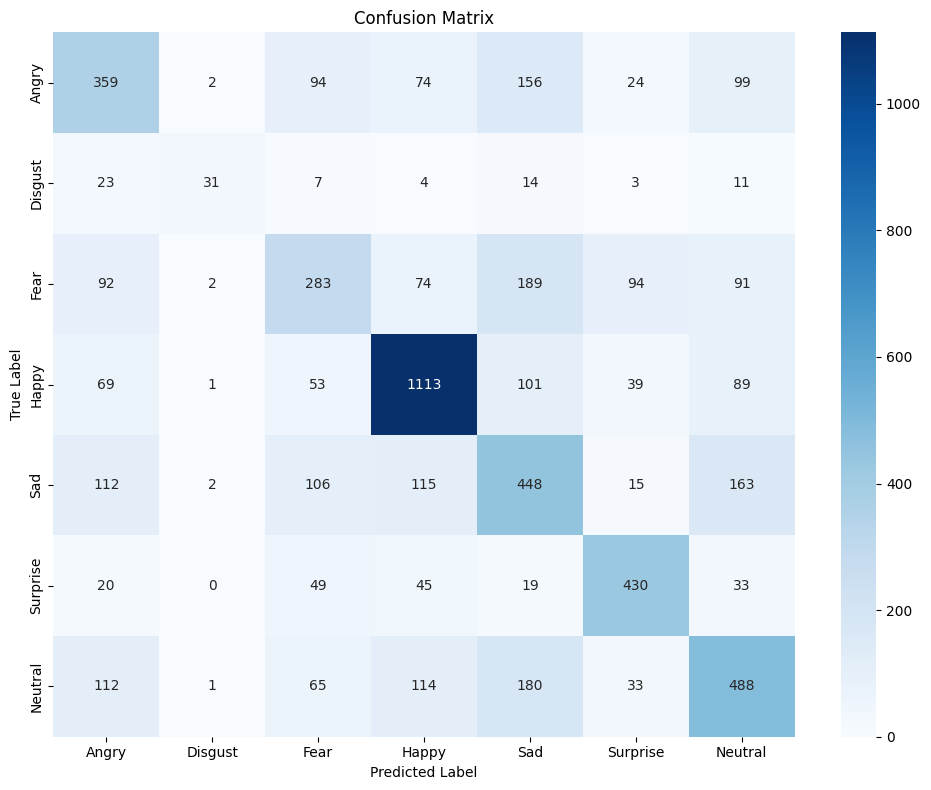

In [ ]:
emotion_names = list(emotion_labels.values())
plot_confusion_matrix(val_targets, val_predictions, emotion_names)
wandb.log({"confusion_matrix": wandb.Image(plt)})


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(val_targets, val_predictions,
                             target_names=emotion_names, output_dict=True)

print("Classification Report:")
print(classification_report(val_targets, val_predictions, target_names=emotion_names))

for emotion, metrics in report.items():
    if emotion in emotion_names:
        wandb.log({
            f"{emotion}_precision": metrics['precision'],
            f"{emotion}_recall": metrics['recall'],
            f"{emotion}_f1": metrics['f1-score']
        })

Classification Report:
              precision    recall  f1-score   support

       Angry       0.46      0.44      0.45       808
     Disgust       0.79      0.33      0.47        93
        Fear       0.43      0.34      0.38       825
       Happy       0.72      0.76      0.74      1465
         Sad       0.40      0.47      0.43       961
    Surprise       0.67      0.72      0.70       596
     Neutral       0.50      0.49      0.50       993

    accuracy                           0.55      5741
   macro avg       0.57      0.51      0.52      5741
weighted avg       0.55      0.55      0.55      5741



In [ ]:
model_path = f'./experiments/{config["experiment_name"]}_model.pth'
os.makedirs('./experiments', exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
    'best_val_accuracy': best_val_acc,
    'final_val_accuracy': val_accuracy,
    'train_accuracies': trainer.train_accuracies,
    'val_accuracies': trainer.val_accuracies,
    'train_losses': trainer.train_losses,
    'val_losses': trainer.val_losses,
    'training_time': training_time,
    'total_parameters': total_params
}, model_path)


In [ ]:
artifact = wandb.Artifact(
    name=f"{config['experiment_name']}_model",
    type="model",
    description=f"Baseline SimpleCNN model with {best_val_acc:.2f}% validation accuracy"
)
artifact.add_file(model_path)
wandb.log_artifact(artifact)


<Artifact baseline_simple_cnn_model>

In [ ]:
wandb.finish()

Angry_f1,▁
Angry_precision,▁
Angry_recall,▁
Disgust_f1,▁
Disgust_precision,▁
Disgust_recall,▁
Fear_f1,▁
Fear_precision,▁
Fear_recall,▁
Happy_f1,▁
Happy_precision,▁
